# UCCS TKET Workshop: Day 2

<br>
<br>

Kathrin Spendier (Quantum Evangelist)
&rarr; <kathrin.spendier@quantinuum.com>, 


Notebook and slides available at: &rarr; https://github.com/spendierk/UCCS-TKET-workshop-2022

## Day 2 Workshop Contents



We will cover the following:
1. Why do we need Quantum Compilers?
2. Necessary Steps for Circuit Compilation
3. Preparing and Running Quantum Circuits on IBM Quito (ibmq_quito)
4. If time: Run on Quantinuum H1 emulator


# 1) Why do we need Quantum Compilers?

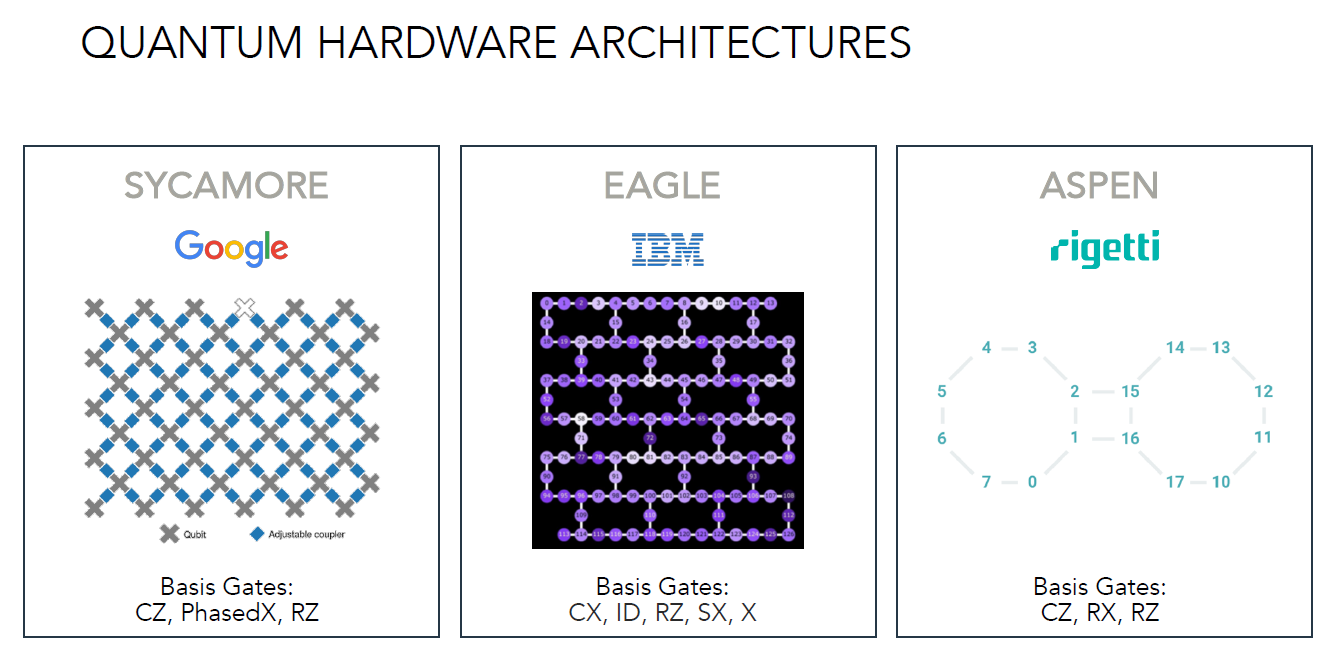

## Noisy Intermediate-Scale Quantum (NISQ)

### NISQ: A term introduced by John Preskill in 2018

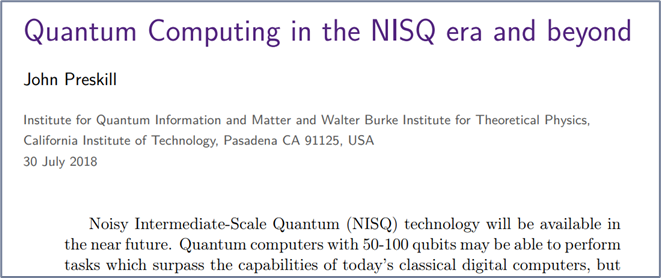


### Intermediate-Scale
- 50 to 100 qubits
- Enough to be hard to simulate
- Not enough for error correction

### Noisy

 - Everything has a limited fidelity
 - Qubits have finite coherence time
 - Errors can vary across the machine
 - Errors can vary across time
 - Errors are correlated
 - Errors are not always well understood


## What do we want to do?

##### GOAL:
Develop a quantum computing toolkit and optimizing compiler to make it easy for people to use gate-level quantum computers to solve their problems.

##### FEATURES:
 - Automatically handles many of the intricacies of NISQ technology.
 - Independent of the language used to apply a given algorithm. 
 - Independent of the quantum computer used to run the circuit.
 - Frees the user to focus on the technique or project they are working on.


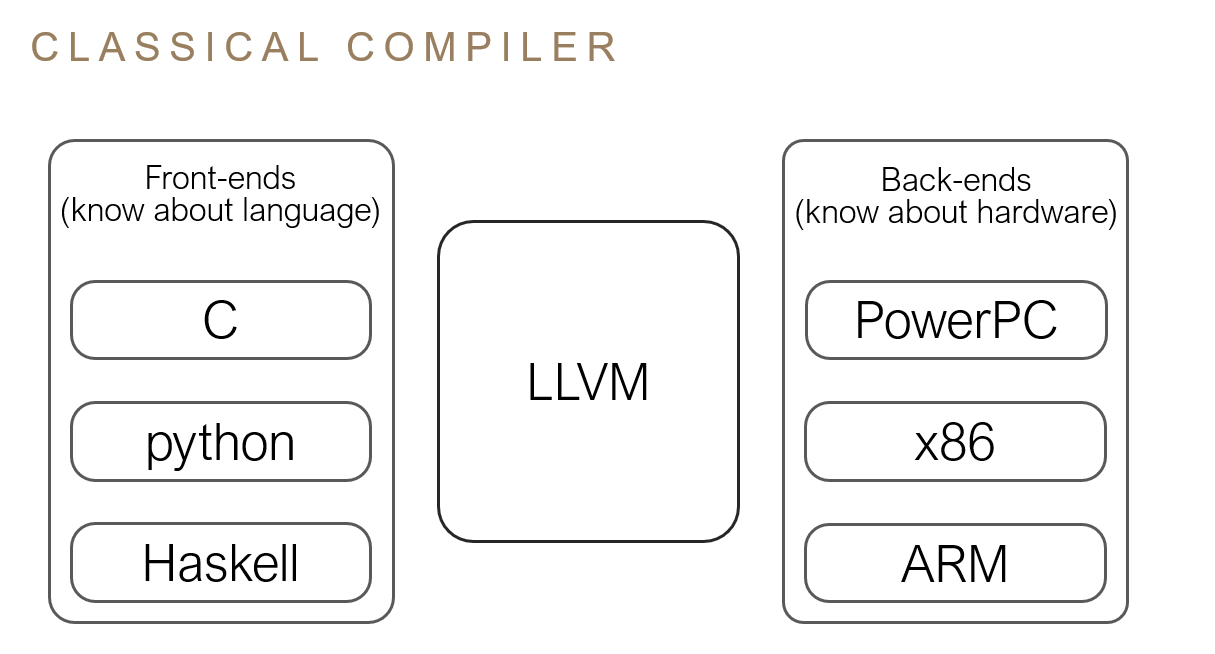

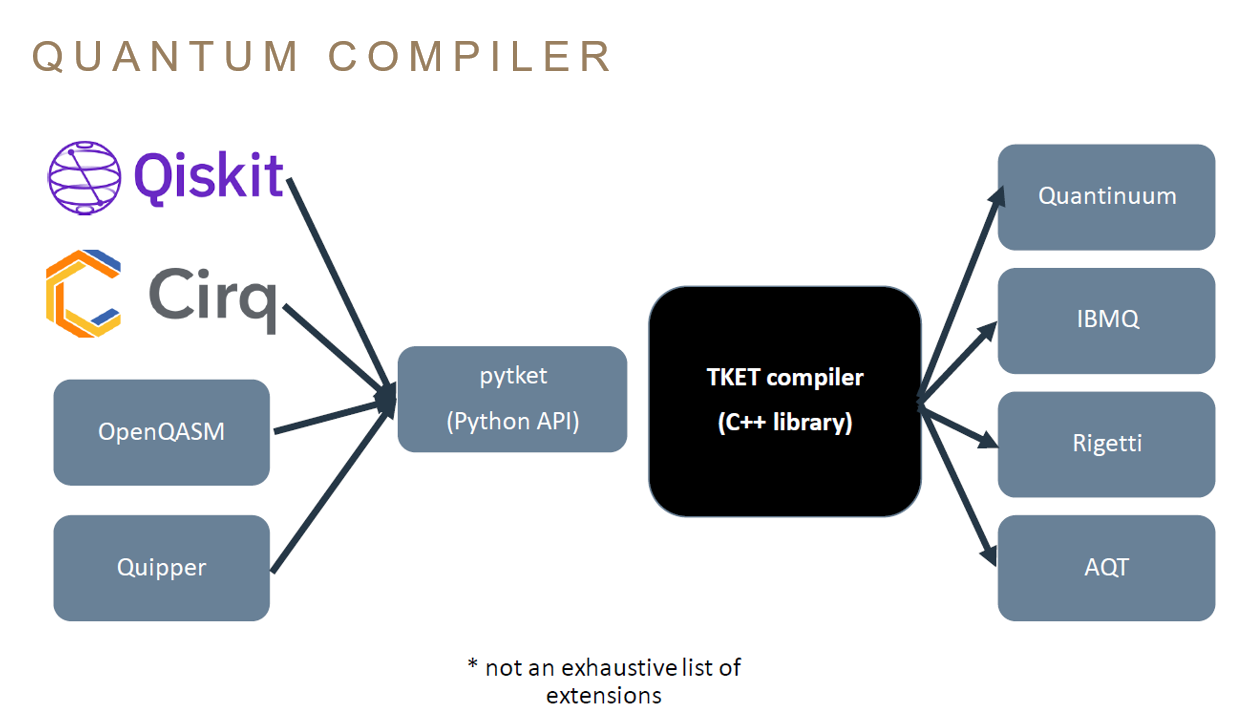

# 2) Necessary Steps for Circuit Compilation

## Example circuit:

After applying the so-called Jordan- Wigner transform, we will focus again on the circuit obtained from a qubit Hamiltonian. This circuit can be used to calculate the ground state energy of molecular Hydrogen, H2, where the two atoms are configured to be at a distance of 0.735 angstroms. 

You can find more information about this transformation here:
https://github.com/Qiskit/qiskit-nature/blob/stable/0.4/docs/tutorials/01_electronic_structure.ipynb

### Hybrid Quantum Computing

A quantum computer and a classical computer working together to solve a problem. 

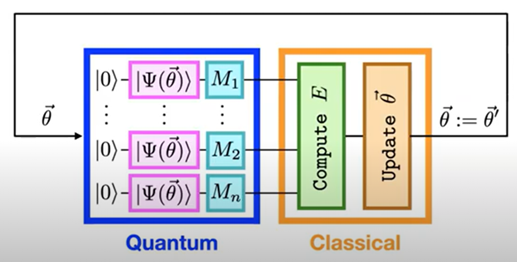

In [1]:
from pytket.qasm import circuit_from_qasm
from pytket.circuit.display import render_circuit_jupyter

circ = circuit_from_qasm('H2JordanWignerMapper.qasm')
render_circuit_jupyter(circ)


#### We aim to optimize this circuit for the ibmq_quito backend and then run it.

## Example Backend: ibmq_quito

Coherence time (~0.1s) is the limit on how long a qubit can retain its quantum state before that state is ruined by noise. 


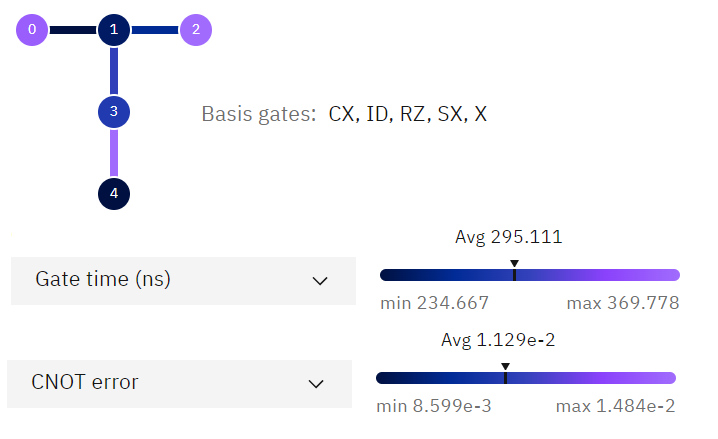

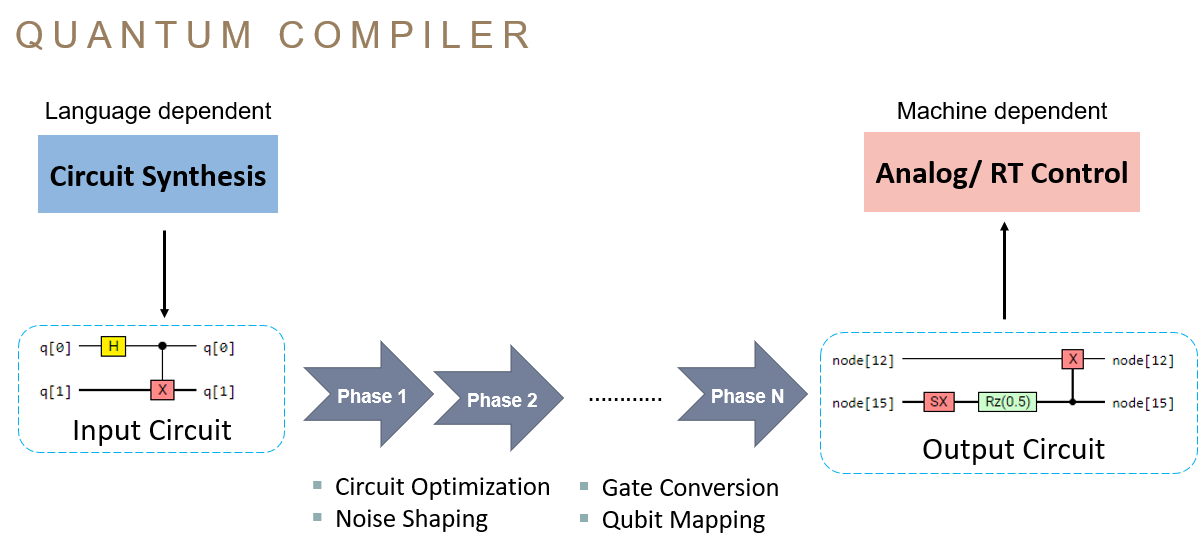

### Predicates

Solving the constraints of the target Backend is the essential goal of compilation, so our choice of passes is mostly driven by this set of constraints.

<code>Backend.required_predicates</code> property gives a collection of predicates, describing the necessary properties a Circuit must satisfy in order to be run.

In [2]:
from pytket.extensions.qiskit import IBMQBackend
from qiskit import IBMQ
#IBMQ.save_account('MY_API_TOKEN') # Save TOKEN to disk
#IBMQ.load_account() # Load account from disk
#IBMQ.providers()    # List all available providers

backend = IBMQBackend('ibmq_quito',hub='ibm-q', group='open', project='main')

print(backend.required_predicates)


[NoSymbolsPredicate, GateSetPredicate:{ Rz U3 U2 U1 X Barrier CX SX Reset noop Measure }]


- NoSymbolsPredicate: Predicate asserting that no gates in the circuit have symbolic parameters.
- U gates are used by IBM
- noop : Identity gate. These gates are not permanent and are automatically stripped by the compiler

In [3]:
from pytket import OpType

print(f"Number of gates = {circ.n_gates}")
print(f"Circuit depth = {circ.depth()}")
print(f"Number of CX gates = {circ.n_gates_of_type(OpType.CX)}")

render_circuit_jupyter(circ)


Number of gates = 150
Circuit depth = 83
Number of CX gates = 56


Calling <code>Backend.valid_circuit()</code> can check whether or not a Circuit satisfies every requirement to run on the Backend

In [4]:
backend.valid_circuit(circ)


False

### Rebase

Substitute each gate in a Circuit with an equivalent sequence of gates in the target gateset according to some known gate decompositions. 

In pytket, we define a rebase to the IBM gateset with <code>auto_rebase_pass</code>.

In [5]:
from pytket.passes import auto_rebase_pass

ibm_rebase = auto_rebase_pass({OpType.X,OpType.SX,OpType.Rz,OpType.CX})
ibm_rebase.apply(circ);
render_circuit_jupyter(circ)

In [6]:
backend.valid_circuit(circ)


True

In [7]:
print(f"Number of gates = {circ.n_gates}")
print(f"Circuit depth = {circ.depth()}")
print(f"Number of CX gates = {circ.n_gates_of_type(OpType.CX)}")


Number of gates = 250
Circuit depth = 115
Number of CX gates = 56


### Question: Why did the total gate count increase from 150 to 250? 

### Placement

- Initially, a Circuit designed without a target device in mind will be expressed in terms of actions on a set of “logical qubits”. 
- A placement (or initial mapping) is a map from these logical qubits to the physical qubits of the device that will be used to carry them. 
- A given placement may be preferred over another if the connectivity of the physical qubits better matches the interactions between the logical qubits caused by multi-qubit gates, or if the selection of physical qubits has better noise characteristics. 
- All of the information for connectivity and noise characteristics of a given Backend is wrapped up in a <code>BackendInfo</code> object by the <code>Backend.backend_info</code> property.

Let's visualize the connectivity of the current circuit after applying the Rebase pass.

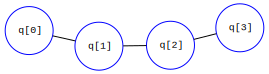

In [8]:
from pytket.utils import Graph

Graph(circ).get_qubit_graph()


We see that we have a linear qubit connectivity. 

Let's have a look at the connectivity of the IBM Quito device (nearest-neighbor).

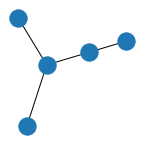

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(backend.backend_info.architecture.coupling)
plt.figure(figsize=(1.8,1.8))
nx.draw(G)
plt.show() # This is how the qubits are laid out on the device


Now we need to place the qubits in the circuit onto the qubit layout of the actual device.

In [10]:
from pytket.passes import PlacementPass, RoutingPass
from pytket.predicates import ConnectivityPredicate
from pytket.placement import GraphPlacement

place = PlacementPass(GraphPlacement(backend.backend_info.architecture))
place.apply(circ)


True

Now the qubits are connected as follows 

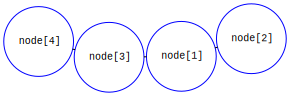

In [11]:
Graph(circ).get_qubit_graph()


Let's check the total number of gates and CNot gates:

In [12]:
print(f"Number of gates = {circ.n_gates}")
print(f"Circuit depth = {circ.depth()}")
print(f"Number of CX gates = {circ.n_gates_of_type(OpType.CX)}")


Number of gates = 250
Circuit depth = 115
Number of CX gates = 56


Stayed the same in this case, but for other circuits it could increase because of possibly needing SWAP gates.

### Optimizations

We need additional techniques we can use to obtain more reliable results by reducing the noise and probability of error. 

- Find an alternative Circuit that is observationally equivalent in a perfect noiseless setting but uses fewer resources (i.e. gates, time). 
- The simplest optimizations will take an inefficient pattern, find all matches in the given Circuit and replace them by the efficient alternative.
- i.e. <code>RemoveRedundancies</code> pass, which looks for a number of easy-to-spot redundant gates, such as zero-parameter rotation gates, gate-inverse pairs, adjacent rotation gates in the same basis, and diagonal rotation gates followed by measurements.

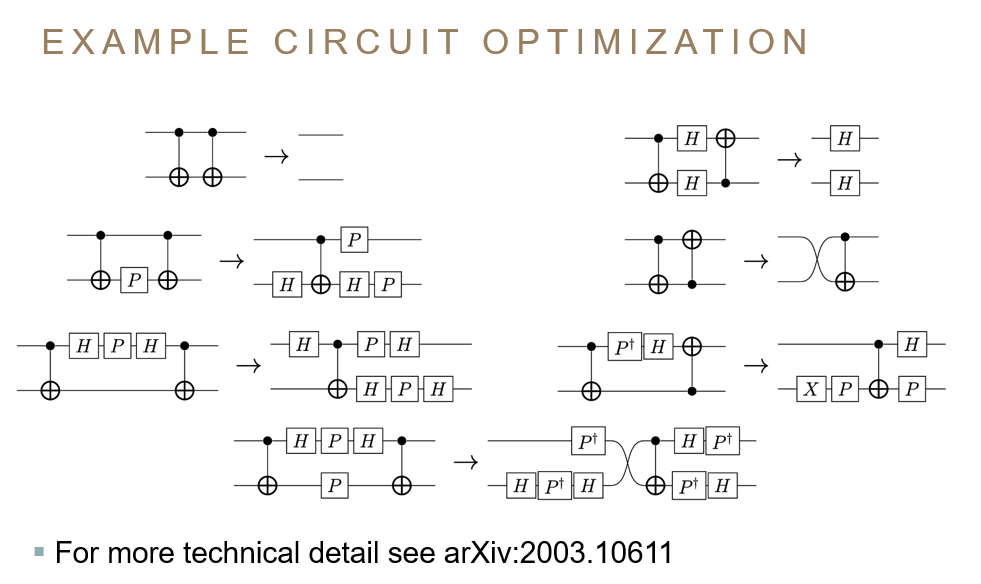

##  The <code>FullPeepholeOptimise</code> Pass

 - Local graph rewrites
 - Pattern-replacement
 - Optimal 1q and 2q subcircuits
 - Commutation- and basis-invariant Clifford reduction

The <code>FullPeepholeOptimise</code> sequence is a combination of <code>CliffordSimp</code>, <code>RemoveRedundancies</code>, <code>CommuteThroughMultis</code>, <code>KAKDecomposition</code>, and <code>EulerAngleReduction</code>

In [13]:
from pytket.passes import SequencePass, FullPeepholeOptimise, RemoveRedundancies

custom_sequence = SequencePass([FullPeepholeOptimise(allow_swaps = False), ibm_rebase])

custom_sequence.apply(circ)
render_circuit_jupyter(circ)
print(f"Number of gates = {circ.n_gates}")
print(f"Circuit depth = {circ.depth()}")
print(f"Number of CX gates = {circ.n_gates_of_type(OpType.CX)}")


Number of gates = 86
Circuit depth = 45
Number of CX gates = 20


## TKET's default pass manager for Backends

TKET has a default pass manager for each backend that is called by:

<p><center> <code> get_compiled_circuit(circuit,optimisation_level) </code> </center>

There are three compilation levels:
- \\( \textsf{Level 0} \\) just solves the device constraints without optimizing.
- \\( \textsf{Level 1} \\) additionally performs some light optimizations. (This level is the default level)
- \\( \textsf{Level 2} \\) adds more intensive optimizations that can increase compilation time for large circuits.

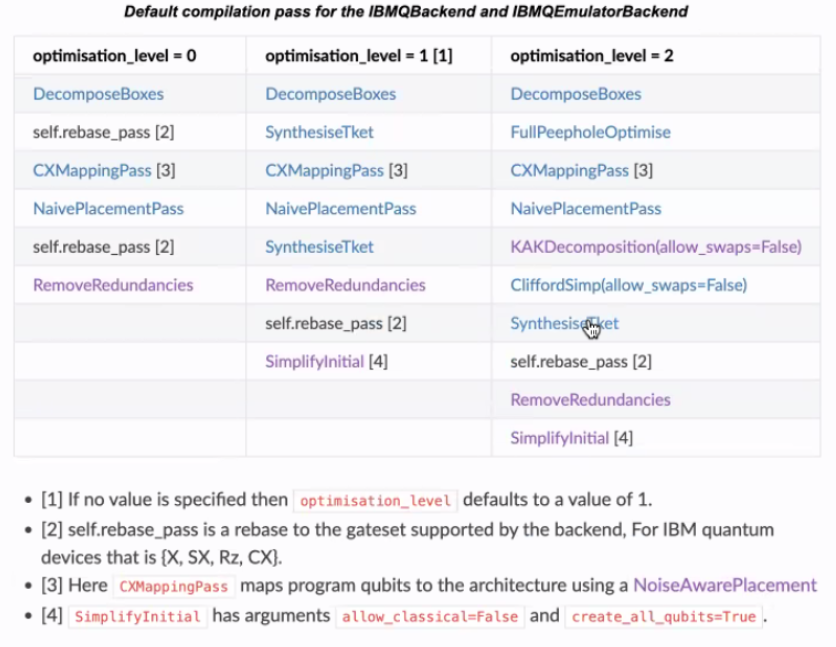

Compile the initial circuit to IBM Quito by solving the device constraints with the default compilation pass and optimization Level 2:

In [14]:
circ_initial = circuit_from_qasm('H2JordanWignerMapper.qasm')
compiled_qft_circ = backend.get_compiled_circuit(circ_initial,2)
render_circuit_jupyter(compiled_qft_circ)

print(f"Number of gates = {compiled_qft_circ.n_gates}")
print(f"Circuit depth = {compiled_qft_circ.depth()}")
print(f"Number of CX gates = {compiled_qft_circ.n_gates_of_type(OpType.CX)}")


Number of gates = 78
Circuit depth = 51
Number of CX gates = 19


# 3) Running Quantum Circuits on IBMQ Quito

We will first run the circuit on the ibmq_quito 
emulator (classical simulator that mimics the connectivity, coherence time, and errors of the device.

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
##################### code for plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_counts(counts):
    counts_record = [{"State":state, "Count":count} for state, count in counts.items()]
    count_df = pd.DataFrame().from_records(counts_record)
    sns.catplot(x='State', y='Count', kind='bar', data=count_df, aspect = 5, height=3)
    plt.show()
############################

### Run circuit on the ibmq_quito emulator  - initial rebase and routing only

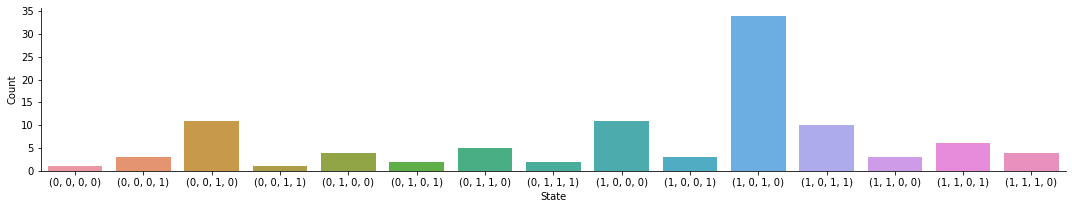

In [18]:
from pytket.extensions.qiskit import IBMQEmulatorBackend 

backend2 = IBMQEmulatorBackend('ibmq_quito',hub='ibm-q', group='open', project='main')

circ_initial = circuit_from_qasm('H2JordanWignerMapper.qasm')
circ_initial.measure_all()

ibm_rebase.apply(circ_initial)

place = PlacementPass(GraphPlacement(backend2.backend_info.architecture))
place.apply(circ_initial)

handle2 = backend2.process_circuit(circ_initial, n_shots=100)
result2 = backend2.get_result(handle2)
counts2=result2.get_counts()
plot_counts(counts2)


In [19]:
counts2

Counter({(0, 0, 0, 0): 1,
         (0, 0, 0, 1): 3,
         (0, 0, 1, 0): 11,
         (0, 0, 1, 1): 1,
         (0, 1, 0, 0): 4,
         (0, 1, 0, 1): 2,
         (0, 1, 1, 0): 5,
         (0, 1, 1, 1): 2,
         (1, 0, 0, 0): 11,
         (1, 0, 0, 1): 3,
         (1, 0, 1, 0): 34,
         (1, 0, 1, 1): 10,
         (1, 1, 0, 0): 3,
         (1, 1, 0, 1): 6,
         (1, 1, 1, 0): 4})

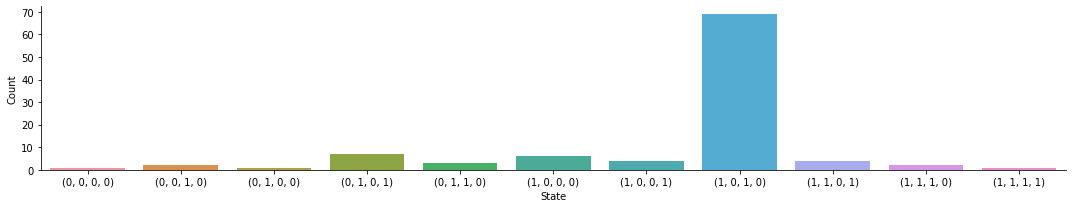

In [20]:
from pytket.extensions.qiskit import IBMQEmulatorBackend 

backend2 = IBMQEmulatorBackend('ibmq_quito',hub='ibm-q', group='open', project='main')
circ_initial = circuit_from_qasm('H2JordanWignerMapper.qasm')
comp_c3=backend2.get_compiled_circuit(circ_initial.measure_all(),2)

handle3 = backend2.process_circuit(comp_c3, n_shots=100)
result3 = backend2.get_result(handle3)
counts3=result3.get_counts()
plot_counts(counts3)


In [21]:
counts3


Counter({(0, 0, 0, 0): 1,
         (0, 0, 1, 0): 2,
         (0, 1, 0, 0): 1,
         (0, 1, 0, 1): 7,
         (0, 1, 1, 0): 3,
         (1, 0, 0, 0): 6,
         (1, 0, 0, 1): 4,
         (1, 0, 1, 0): 69,
         (1, 1, 0, 1): 4,
         (1, 1, 1, 0): 2,
         (1, 1, 1, 1): 1})

### Running on actual Quito

When you submit a job to a IBMQ quantum computer, it enters the scheduler for the specific system, joining the pool of jobs (from all users) that are waiting to be executed on that system. You may be in the queued for hours until your circuit runs on the device.

Job Status: job has successfully run


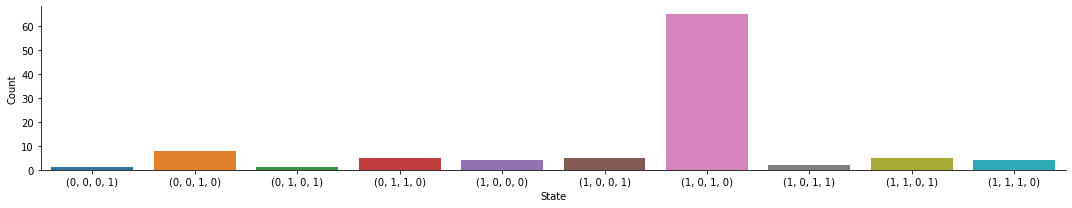

In [21]:
from pytket.extensions.qiskit import IBMQBackend 

backend4 = IBMQBackend('ibmq_quito',hub='ibm-q', group='open', project='main')
circ_initial = circuit_from_qasm('H2JordanWignerMapper.qasm')
comp_c4=backend4.get_compiled_circuit(circ_initial.measure_all(),2)

handle4 = backend4.process_circuit(comp_c4, n_shots=100)
result4 = backend4.get_result(handle4)
counts4 = result4.get_counts()
plot_counts(counts4)

In [22]:
counts4

Counter({(0, 0, 0, 1): 1,
         (0, 0, 1, 0): 8,
         (0, 1, 0, 1): 1,
         (0, 1, 1, 0): 5,
         (1, 0, 0, 0): 4,
         (1, 0, 0, 1): 5,
         (1, 0, 1, 0): 65,
         (1, 0, 1, 1): 2,
         (1, 1, 0, 1): 5,
         (1, 1, 1, 0): 4})

### Results (vary slightly between runs)
<br>

| Compiler | Compiler Version | Backend | Optimization Level | Total # of Gates | 2-qubit Gates |Counts for "1,0,1,0" state out of 100 |
| --- | --- | --- | --- | --- | --- | --- |
| TKET | 1.8.1 |Perfect Simulator |- | 150 | 56 | 100? |
| TKET | 1.8.1 |Quito Emulator | route & place | 250 | 115 | 34|
| TKET | 1.8.1 |Quito Emulator | 2 | 78| 19 | 69 |
| TKET | 1.8.1 |Quito  | 2 | 78| 19 | 65 |

<br>

In today’s NISQ area, this difference in the reduction of the number of gates and hardware noise performance can matter deciding between the success and failure of implementing a circuit on a real quantum computer.

# Day 2 Homework:

1) For the H2JordanWignerMapper.qasm circuit, do you indeed get 100% probability for state |1010> with a classical similator?
 <br>
 <br>
2) Optimize and run the following circuit on IBMQ Oslo and verify your result with a classical simulator. You can use TKET's default compilation pass. Do you notice any difference between compilation levels 0 and 2? How did the qubit connectivity in the circuit change after optimization?
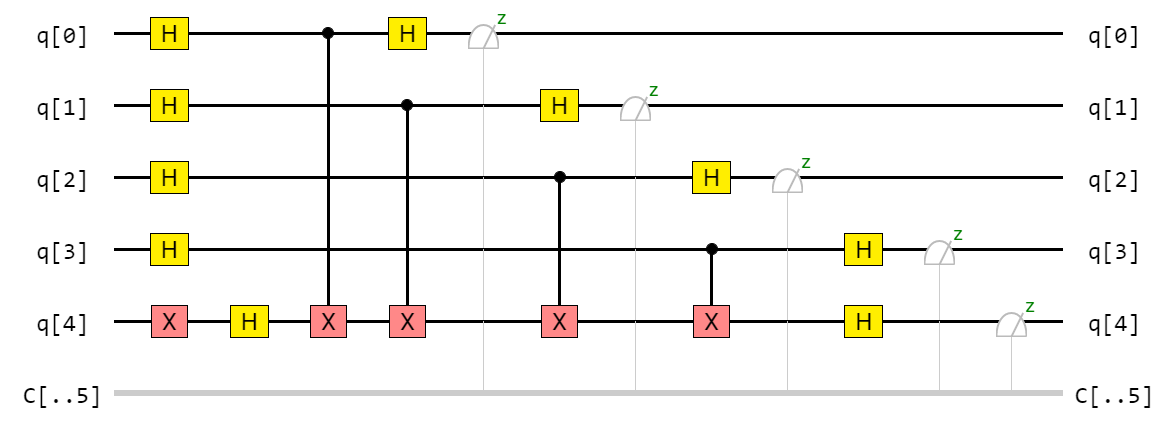

# NEXT : Shor's Algorithm

We will discuss Shor’s factoring algorithm and implement it on different backends. While doing this, we will also learn about the quantum Fourier transform, the unitary operator, and quantum phase estimation.

# If time: Run on Quantinuum H1 emulator

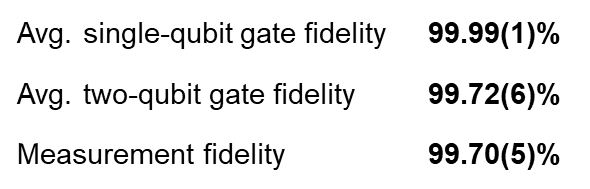

### Access to Quantinuum and IonQ Backends

You can get access to [Quantinuum](https://www.quantinuum.com/) and [IonQ](https://ionq.com/) simulators, emulators, and quantum machines through Microsoft Azure. When creating your workspace, first-time users automatically get free 500 (USD) Azure Quantum Credits for use with each participating quantum hardware provider. If you have consumed all the credits and need more, you can apply to the [Azure Quantum Credits program](https://microsoft.qualtrics.com/jfe/form/SV_3fl9dfFrkC3g0aG?aq_source=organic). For this Hackathon, we will use the simulators and emulators that do not use Azure Quantum Credits and hence are entirely free.

In [1]:
# pip install pytket-qsharp
# from pytket.extensions.qsharp import AzureBackend

## call H1-1 Emulator
#backend3 = AzureBackend("quantinuum.hqs-lt-s1-sim",resourceId="your resource ID",location="westus")


For more detailed instructions, look at the https://github.com/spendierk/Q-SITE-Toronto-2022 repository:
https://github.com/spendierk/Q-SITE-Toronto-2022/blob/main/Access%20to%20Quantinuum%20and%20IonQ%20Backends.ipynb

In [29]:
## I will use my direct access to the Quantinuum backend

# first run
#pip install pytket-quantinuum

from pytket.extensions.quantinuum import QuantinuumBackend

backend5 = QuantinuumBackend('H1-1E') # emulator

circ_initial = circuit_from_qasm('H2JordanWignerMapper.qasm')
comp_c5=backend5.get_compiled_circuit(circ_initial.measure_all(),2)

print(f"Our circuit has {comp_c5.n_gates} quantum gates in total and an overall")
print(f"depth of {comp_c5.depth()}.")
print(f"Of these gates {comp_c5.n_gates_of_type(OpType.ZZMax)} are two qubit gate, ZZMax, counts.")


Enter your Quantinuum email: kathrin.spendier@quantinuum.com
Enter your Quantinuum password: ········
Our circuit has 56 quantum gates in total and an overall
depth of 36.
Of these gates 17 are two qubit gate, ZZMax, counts.


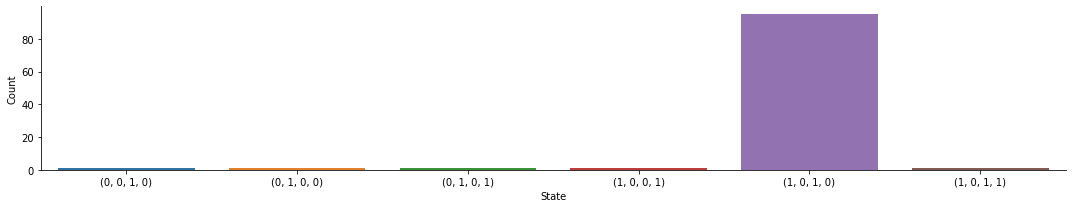

Counter({(0, 0, 1, 0): 1,
         (0, 1, 0, 0): 1,
         (0, 1, 0, 1): 1,
         (1, 0, 0, 1): 1,
         (1, 0, 1, 0): 95,
         (1, 0, 1, 1): 1})

In [30]:
handle5 = backend5.process_circuit(comp_c5, n_shots=100)
result5 = backend5.get_result(handle5)
counts5=result5.get_counts()
plot_counts(counts5)
counts5

### Results (vary slightly between runs)
<br>

| Compiler | Compiler Version | Backend | Optimization Level | Total # of Gates | 2-qubit Gates |Counts for "1,0,1,0" state out of 100 |
| --- | --- | --- | --- | --- | --- | --- |
| TKET | 1.8.1 |Perfect Simulator |- | 150 | 56 | 100? |
| TKET | 1.8.1 |Quito Emulator | route & place | 250 | 115 | 34|
| TKET | 1.8.1 |Quito Emulator | 2 | 78| 19 | 69 |
| TKET | 1.8.1 |Quito  | 2 | 78| 19 | 65 |
| TKET | 1.8.1 |H1-1 Emulator | 2 | 56 | 17 | 95 |

